In [12]:
# image shadow removal test

import cv2
import numpy as np

def remove_shadows(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # Use adaptive thresholding to detect shadows
    # Shadows are typically darker, so we use THRESH_BINARY_INV
    _, shadow_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Dilate the shadow mask to cover the shadow edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_CLOSE, kernel)

    # Inpaint the shadow regions using the mask
    result = cv2.inpaint(image, shadow_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Save the result
    cv2.imwrite(output_path, result)
    print(f"Shadow-removed image saved to {output_path}")

    # Optional: Display the results
    cv2.imshow("Original Image", image)
    cv2.imshow("Shadow Mask", shadow_mask)
    cv2.imshow("Shadow-Removed Image", result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
input_image_path = "data/test/test_3.jpg"  # Replace with your image path
output_image_path = "output_image.jpg"  # Replace with your desired output path


remove_shadows(input_image_path, output_image_path)

Shadow-removed image saved to output_image.jpg


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

In [6]:
# Load the Trained Model
from deshadownet import DeshadowNet
import matplotlib.pyplot as plt

def load_model(model_path, device):
    model = DeshadowNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    return model

# Preprocess the Input Image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Postprocess the Output Image
def postprocess_image(output_tensor):
    output_tensor = output_tensor.squeeze(0)  # Remove batch dimension
    output_tensor = output_tensor.clamp(0, 1)  # Ensure values are in [0, 1]
    output_image = transforms.ToPILImage()(output_tensor.cpu())
    return output_image

# Inference Function
def infer(model, image_path, device, output_path):
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to match model input size
        transforms.ToTensor(),          # Convert to tensor
    ])
    
    # Preprocess the input image
    input_tensor = preprocess_image(image_path, transform).to(device)
    
    # Perform inference
    with torch.no_grad():  # Disable gradient calculation
        output_tensor = model(input_tensor)
    
    # Postprocess the output image
    output_image = postprocess_image(output_tensor)
    
    # Save the output image
    output_image.save(output_path)
    print(f"Shadow-free image saved to {output_path}")
    
    # Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Output Image")
    plt.imshow(output_image)
    plt.axis("off")
    
    plt.show()

Using device: cuda
Shadow-free image saved to output_image.jpg


/tmp/ipykernel_71022/3375952735.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


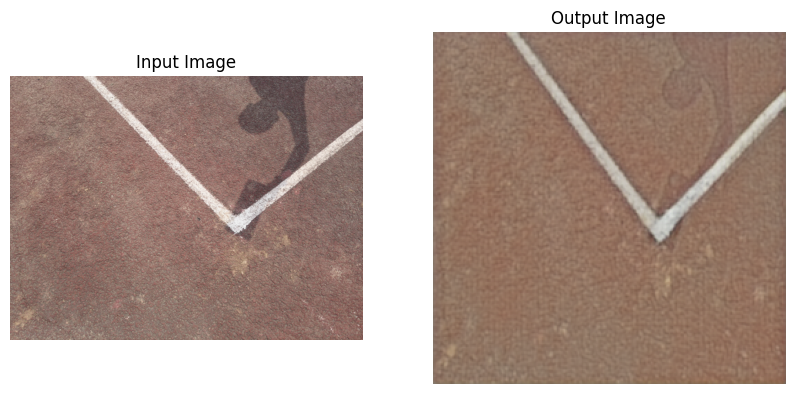

In [14]:
# Paths
model_path = "deshadownet_best.pth"  # Path to the trained model
input_image_path = "data/ISTD_Dataset/train/train_A/1-1.png"  # Path to the input image with shadows
output_image_path = "output_image.jpg"  # Path to save the shadow-free image

# Device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model
model = load_model(model_path, device)

# Perform inference
infer(model, input_image_path, device, output_image_path)